# Coursera 
## Applied data science capstone
### Week 5: Data exploitation

# PROBLEM DEFINITION

A Taxy company wants to set up its business in Milano city, Italy. The business idea is to be affiliated with all the Hotels in the radius of 1.5km from the city center so as to exploit their smart mobility transport service solutions. They want to offer the fastest pick up service to be as effective and fast as possible. For this reason they are looking for the perfect positioning for their headquartier. The rationale is to find the place that minimize the average distance from all Hotels in the very citycenter. Assuming an average speed of 10 km per hour to move in the city (https://www.statista.com/statistics/264703/average-speed-in-europes-15-most-congested-cities/) and neglecting all mobility and all congestion issues we want to define an estimation for a taxi service to reach every Hotel.

In [1]:
# Import package
import folium

# Define coordinates
Latitude = 45.465586
Longitude = 9.185944
# Create map of Milano 
MilanoMap = folium.Map(location=[Latitude, Longitude], zoom_start=14)
MilanoMap

# Data collection
We use Fouresquare data to get the cooridnates for every hotel, *use the tag 'Hotel'* in the Foursquare API and select a radius of '1500' meters from Cordusio square, this distance approximate the restricted-traffic zone of the city. Notice that using a free developer account we retrive up to 100 places only so using the 'query' tag is particularly useful. Finally we can put all the Hotel on the map togheter with the circle defining the interested area.

In [2]:
# Import Packages
import requests
from pandas import json_normalize

# Set Foursquare API
CLIENT_ID = '02QBHIMZSD0O05JYQX4MBB0KOZR1KH3V2TQ34PV0CH1FKBEU' 
CLIENT_SECRET = 'NNGC5E03TOWAXLIWW1ERT03PH5T3YFFN1124KLOM31F5AE44'
VERSION = '20180605' 
LIMIT = 1000 
RADIUS = 1500
QUERY = ['Hotel'] 

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Latitude, 
    Longitude,  
    RADIUS, 
    LIMIT,
    QUERY
)
# get results
results = requests.get(url).json()
# Extract venues information
venues = results['response']['groups'][0]['items']
# flatten JSON format
venues = json_normalize(venues) 
# filter columns 
venues = venues.loc[:, ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
# filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis=1)
# clean columns
venues.columns = [col.split(".")[-1] for col in venues.columns]
# Define hotels dataframe
MilanoHotel = venues
# Print results
print('There are',MilanoHotel.shape[0],'Hotels in the area')
# Print results
MilanoHotel.head(10)

There are 95 Hotels in the area


,name,categories,lat,lng
0,Park Hyatt Milan,Hotel,45.465532,9.188911
1,Room Mate Giulia Hotel,Hotel,45.465250,9.189396
2,BVLGARI Hotel Milano,Hotel,45.470149,9.189318
3,Mandarin Oriental,Hotel,45.469461,9.190876
4,Armani Hotel Milano,Hotel,45.470478,9.192882
5,Starhotels Rosa Grand,Hotel,45.464122,9.193692
6,Four Seasons Hotel Milano,Hotel,45.469372,9.195466
7,The Square,Hotel,45.461003,9.189338
8,HMS Hotel Milano Scala,Hotel,45.469061,9.186865
9,Hotel Spadari al Duomo,Hotel,45.463738,9.187130


In [6]:
for idx in MilanoHotel.index :
    folium.CircleMarker(
        [MilanoHotel.iloc[idx,2], MilanoHotel.iloc[idx,3]],
        radius=5,
        color = 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(MilanoMap)  

folium.Circle(
        [Latitude, Longitude],
        radius=RADIUS,
        color = 'red',
        fill=False,
        parse_html=False).add_to(MilanoMap) 

MilanoMap

# USING OUR DATA: Metodology
We want to use the data to define the best location for the headquartier. Lets $x$ and $y$ be our the Headquartier coordianates, and lets $H_x^i$ and $H_y^i$ the coordinates of each Hotel $i$.
We can express the average distance $d$ using the formula
$$ d=\frac{1}{N}\sum_i^N\sqrt{(x-H_x^i)^2+(y-H_y^i)^2} $$
We can use operational resarch approach to find the position formulating a minimization problem. We can make use of Scipy's optimize library to numerically solve the problem. 

Optimization terminated successfully.
The optimal position coordinates are [45.46494392  9.18899495]
The minimum average distance is 721.14 meters
The minimum average travelling time @10km/h is 4.0 minutes


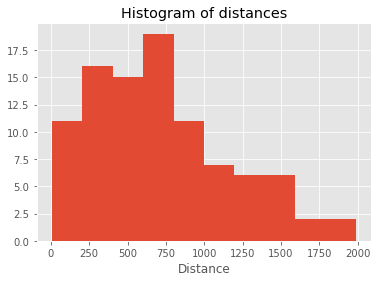

In [7]:
# Import the packages
import numpy as np
from scipy.optimize import minimize

# Define the distance function
def MapDistance(x,H):
    # c is a coefficent that converts coordinates into meters 
    c = 100000;
    return np.sum(np.sqrt(np.sum(np.square((x-H)*c),axis=1)))/H.shape[0]

# Define the array of coordinates of every hotel
H = MilanoHotel[['lat','lng']].to_numpy()
# Define an guess initial position as the very center
x0 = np.array([Latitude, Longitude])
# Solve the minimization problem
res = minimize(MapDistance, x0, H, method = 'Nelder-Mead')

# Print results
print(res.message)
print('The optimal position coordinates are',res.x)
print('The minimum average distance is',np.round(MapDistance(res.x,H),2),'meters')
print('The minimum average travelling time @10km/h is',np.round(MapDistance(res.x,H)/1000/10*60,0),'minutes')

# Retrive every distance
MilanoHotel['distance'] = 0
for idx in MilanoHotel.index:
   # To overcome the fact that np.sum does not work on one dimension we have to hack the function call.
   h = np.array([res.x, H[idx]])
   MilanoHotel.iloc[idx,4] = np.round(MapDistance(res.x,h)*2,2)

# Print the distances 

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(MilanoHotel['distance'], bins = 10)
plt.xlabel('Distance')
plt.title('Histogram of distances')
plt.show()

In [8]:
folium.CircleMarker(
        res.x,
        radius=5,
        color = 'red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(MilanoMap)  
MilanoMap

# CONCLUSIONS
The best place to set a fast taxi service for hotels in Milano is just nearby the cathedral. The result is not surprising, the hotel distribution on the map is fairly concentrated into the city center. Hovewer this is not in the very center and there are hotels that are actually more distant than the considered 1.5km from the real center. In a more precise study one should take into account road distance instead of geographical distance, traffic limitations and congestion should be considered too. Another important thing one could consider is the number of calls each hotel makes in order to weight their importance: the latter implementation is straightforward by adding a weighting coefficient $W_i$ in the formula to represent the number of calls of the hotel $i$
$$ d=\frac{1}{N}\sum_i^NW_i\sqrt{(x-H_x^i)^2+(y-H_y^i)^2} $$